## Predicting Walmart's Quarterly Earnings - Pytorch LSTM Example
### Applying LSTMs to Predict Quarterly Earnings

This is the code accompanying my Medium article which you can find linked in the ReadMe. The code blocks follow the same pattern as those in the article!

In [1]:
#-- Necessary Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
df = pd.read_csv('WMT_Earnings.csv', index_col='Date')
#-- Using this we can select the amount of data to use, some of the very early years 
#- aren't formatted properly and will throw an error
df=df.iloc[:50]
#-- Change the dates into a format that pandas will recognise
df.index = [df.index[i].split()[0]+" "+df.index[i].split()[2] for i in range(len(df.index))]
#-- Set index to correct format
df.index = pd.to_datetime(df.index)
#-- Put the data in chronological order
df = df.iloc[::-1]
#-- Only select data up to end of 2019
df = df[:"2019"]
#-- Remove the B (standing for billion) from the values and store as float rather than a string
df.Value = [float(df.Value[i][:-1]) for i in range(len(df.Value))]

In [3]:
from sklearn.preprocessing import MinMaxScaler
test_size = 7

train = df[:-test_size].values
test = df[-test_size:].values

scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

In [4]:
train_scaled = torch.FloatTensor(train_scaled)
print(f'Original dimensions : {train_scaled.shape}')
train_scaled = train_scaled.view(-1)
print(f'Correct dimensions : {train_scaled.shape}')

Original dimensions : torch.Size([36, 1])
Correct dimensions : torch.Size([36])


In [5]:
def get_x_y_pairs(data, n_past, n_future):
    """
    train_scaled - training sequence
    train_periods - How many data points to use as inputs
    prediction_periods - How many periods to ouput as predictions
    """
    _x = [data[i:i+n_past] for i in range(len(data)-n_past-n_future+1)]
    _y = [data[i+n_past:i+n_past+n_future] for i in range(len(data)-n_past-n_future+1)]
    
    #-- use the stack function to convert the list of 1D tensors
    # into a 2D tensor where each element of the list is now a row
    _x = torch.stack(_x)
    _y = torch.stack(_y)
    
    return _x, _y

In [6]:
n_past=16
n_future=7
data_x, data_y = get_x_y_pairs(train_scaled, n_past, n_future)

In [7]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, data_x, data_y, n_past, n_future):
        self.data_x = data_x
        self.data_y = data_y
        self.n_past = n_past
        self.n_future = n_future
        
        
    def __len__(self):
        return len(self.data_x)
    
    def __getitem__(self, idx):
        return self.data_x[idx].reshape(-1,1), self.data_y[idx]

In [8]:
tr_dataset = CustomDataset(data_x, data_y, n_past, n_future)

In [9]:
tr_dataloader = DataLoader(dataset=tr_dataset, 
                           batch_size=4,
                           shuffle=False,
                           num_workers=2
                          )

In [10]:
class LSTM(nn.Module):
    """
    input_size - will be 1 in this example since we have only 1 predictor (a sequence of previous values)
    hidden_size - Can be chosen to dictate how much hidden "long term memory" the network will have
    output_size - This will be equal to the prediciton_periods input to get_x_y_pairs
    """
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, self.num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(self.num_layers,x.shape[0],self.hidden_size),
                           torch.zeros(self.num_layers,x.shape[0],self.hidden_size))
        else:
            self.hidden = hidden
            
        """
        inputs need to be in the right shape as defined in documentation
        - https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        
        lstm_out - will contain the hidden states from all times in the sequence
        self.hidden - will contain the current hidden state and cell state
        """
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        
        predictions = self.linear(lstm_out[:,-1])

        
        return predictions, self.hidden

In [19]:
model = LSTM(input_size=1, hidden_size=16, output_size=n_future, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
epochs = 1000
model.train()
for epoch in range(epochs+1):
    for x,y in tr_dataloader:
        y_hat, _ = model(x, None)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    if epoch%100==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')


epoch:    0 loss:0.62173086
epoch:  100 loss:0.01605563
epoch:  200 loss:0.01560921
epoch:  300 loss:0.01465920
epoch:  400 loss:0.01402501
epoch:  500 loss:0.01325886
epoch:  600 loss:0.01202122
epoch:  700 loss:0.00921299
epoch:  800 loss:0.00536179
epoch:  900 loss:0.00151056
epoch: 1000 loss:0.00135308


In [21]:
model.eval()
with torch.no_grad():
    predictions, _ = model(train_scaled[-test_size:].view(1,-1,1), None)
#-- Apply inverse transform to undo scaling
predictions = scaler.inverse_transform(np.array(predictions.reshape(-1,1)))

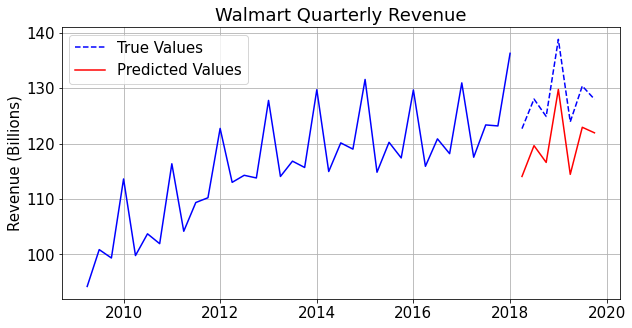

In [23]:
x = [dt.datetime.date(d) for d in df.index]
font = {'size'   : 15}

mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.title('Walmart Quarterly Revenue')
plt.ylabel('Revenue (Billions)')
plt.grid(True)
plt.plot(x[:-len(predictions)],
         train,
         "b-")
plt.plot(x[-len(predictions):],
         test,
         "b--",
         label='True Values')
plt.plot(x[-len(predictions):],
         predictions,
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)

In [24]:
model

LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (linear): Linear(in_features=16, out_features=7, bias=True)
)

In [27]:
torch.save(model, 'model.pt')